In [409]:
import numpy as np
import torch as tc
import random
from torch.utils.data import Dataset, DataLoader
import seaborn as sb
from Classes import *
from functions import *
from Train_Env import *

0
torch.Size([730, 189]) tensor(69321, device='cuda:0')
[tensor([[0.5101],
        [0.5110],
        [0.5111],
        [0.5111],
        [0.5111]])]


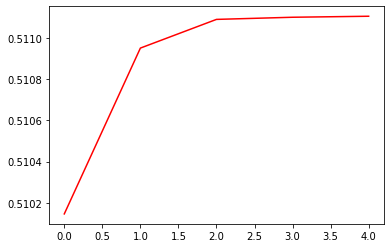

5
torch.Size([730, 189]) tensor(68864, device='cuda:0')
[tensor([[0.5101],
        [0.5110],
        [0.5111],
        [0.5111],
        [0.5111]]), tensor([[0.6277],
        [0.6535],
        [0.6592],
        [0.6581],
        [0.6583]])]


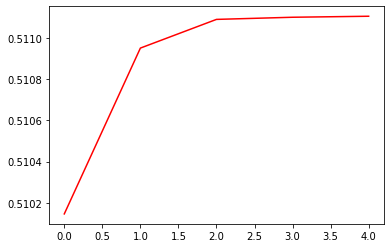

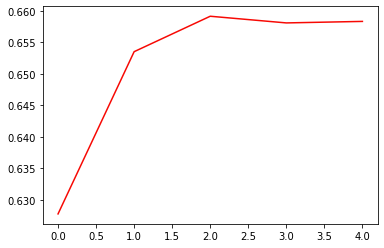

10
torch.Size([730, 189]) tensor(69167, device='cuda:0')
[tensor([[0.5101],
        [0.5110],
        [0.5111],
        [0.5111],
        [0.5111]]), tensor([[0.6277],
        [0.6535],
        [0.6592],
        [0.6581],
        [0.6583]]), tensor([[0.6116],
        [0.6242],
        [0.6285],
        [0.6280],
        [0.6294]])]


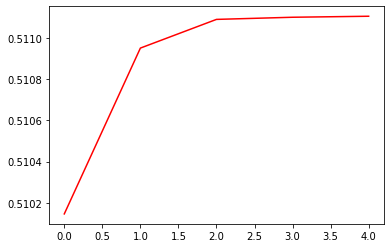

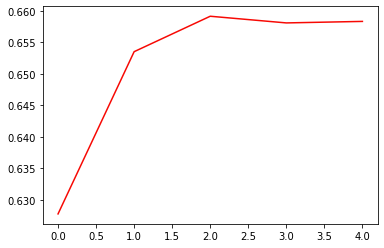

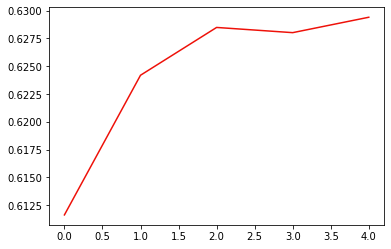

15
torch.Size([730, 189]) tensor(68867, device='cuda:0')
[tensor([[0.5101],
        [0.5110],
        [0.5111],
        [0.5111],
        [0.5111]]), tensor([[0.6277],
        [0.6535],
        [0.6592],
        [0.6581],
        [0.6583]]), tensor([[0.6116],
        [0.6242],
        [0.6285],
        [0.6280],
        [0.6294]]), tensor([[0.5927],
        [0.6009],
        [0.6050],
        [0.6041],
        [0.6069]])]


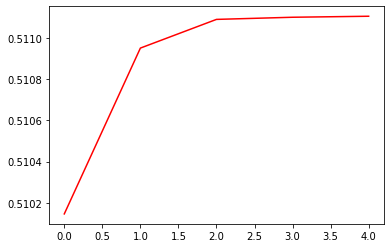

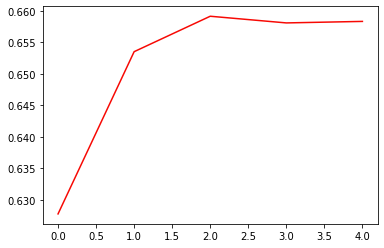

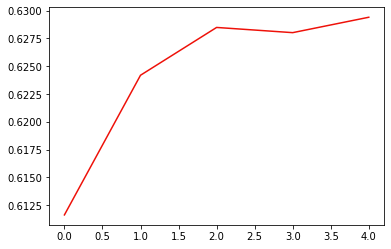

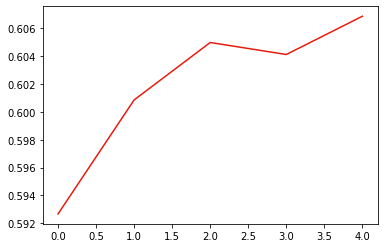

20
torch.Size([730, 189]) tensor(68977, device='cuda:0')
[tensor([[0.5101],
        [0.5110],
        [0.5111],
        [0.5111],
        [0.5111]]), tensor([[0.6277],
        [0.6535],
        [0.6592],
        [0.6581],
        [0.6583]]), tensor([[0.6116],
        [0.6242],
        [0.6285],
        [0.6280],
        [0.6294]]), tensor([[0.5927],
        [0.6009],
        [0.6050],
        [0.6041],
        [0.6069]]), tensor([[0.5555],
        [0.5599],
        [0.5652],
        [0.5648],
        [0.5666]])]


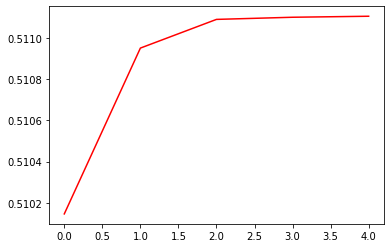

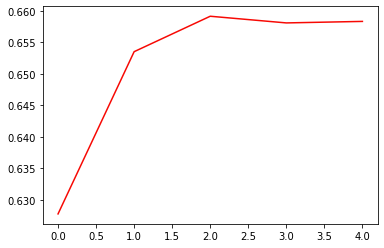

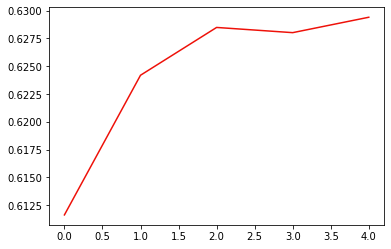

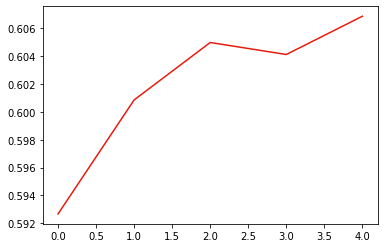

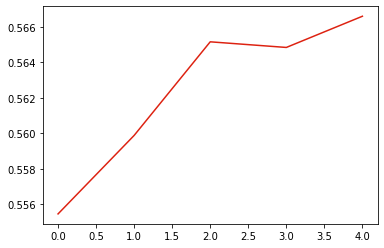

25
torch.Size([730, 189]) tensor(68931, device='cuda:0')
[tensor([[0.5101],
        [0.5110],
        [0.5111],
        [0.5111],
        [0.5111]]), tensor([[0.6277],
        [0.6535],
        [0.6592],
        [0.6581],
        [0.6583]]), tensor([[0.6116],
        [0.6242],
        [0.6285],
        [0.6280],
        [0.6294]]), tensor([[0.5927],
        [0.6009],
        [0.6050],
        [0.6041],
        [0.6069]]), tensor([[0.5555],
        [0.5599],
        [0.5652],
        [0.5648],
        [0.5666]]), tensor([[0.4821],
        [0.4792],
        [0.4809],
        [0.4811],
        [0.4814]])]


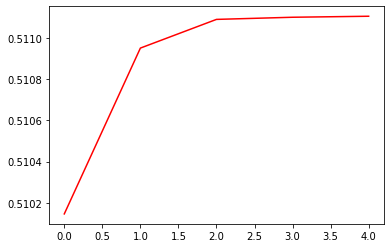

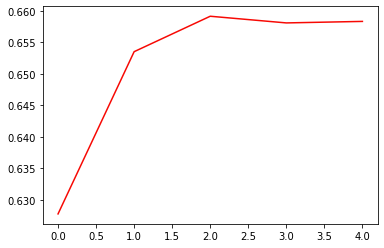

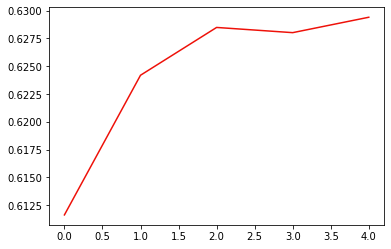

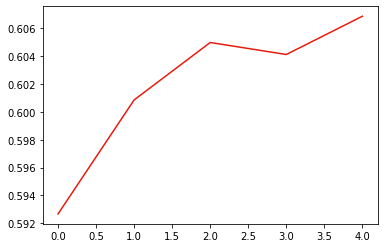

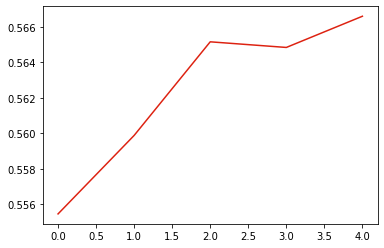

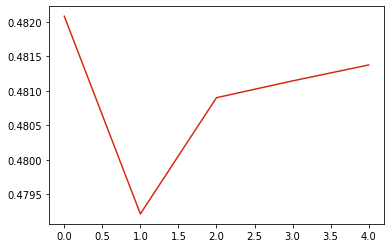

tensor([[0.5101, 0.6277, 0.6116, 0.5927, 0.5555, 0.4821],
        [0.5110, 0.6535, 0.6242, 0.6009, 0.5599, 0.4792],
        [0.5111, 0.6592, 0.6285, 0.6050, 0.5652, 0.4809],
        [0.5111, 0.6581, 0.6280, 0.6041, 0.5648, 0.4811],
        [0.5111, 0.6583, 0.6294, 0.6069, 0.5666, 0.4814]])

In [7]:
data_with_names = pd.read_csv('../data2/TCPA_data_sel.csv')
ID, data = data_with_names.iloc[:,:2], tc.tensor(data_with_names.iloc[:,2:].values)

train_dist = ((0.1,0.9))
test_dist = (0.50)
activations = [nn.ReLU()]
n_epochs = 30
test_every = 5
width =40
depth= 4
variational = True
lr = 0.0001

train_env = Train_env(data, load_model=False)  # specify network
train_env.train_network(width, depth, variational, train_dist, test_dist, n_epochs=n_epochs, test_every=test_every) # specify training and test

In [333]:
class Normaldataset(Dataset):
    def __init__(self, data):
        self.data = data
 
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, i):
        return self.data[i, :].float()
    

class Mask_n():
    def __init__(self, data, batchsize):
        self.dataset = Normaldataset(data)
        self.nsamples, self.nfeatures = data.shape
        self.batchsize = batchsize
        self.dataloader = DataLoader(self.dataset, batchsize, shuffle=False)
        self.mask = [tc.tensor(np.random.permutation(self.nfeatures)) for _ in range(self.batchsize)]
        self.seed = random.random()
        
    def get_nmasked(self, n): # müsste get_n_unmasked heißen......
        n = self.nfeatures-n # einmal umgedreht
        batch = next(iter(self.dataloader))
        masked_data, target_data = batch.clone(), batch.clone()
        for i in range(self.batchsize):
            masked_data[i][self.mask[i][:n]] = float('nan')
        
        last_mask = [mask[-1] for mask in self.mask]
        
        return masked_data.float(), target_data.float(), last_mask
    
mask_n = Mask_n(data, 10)
ind = mask_n.get_nmasked(5)[2]


In [428]:
'''
###batched
class MCShapley:
    def __init__(data, net, truncation):
        self.data = data
        self.nsamples, self.nfeatures = data.shape
        self.net = net
        self.truncation = truncation
        self.criterion = F.mse_loss
        
        self.phi = tc.zeros(self.nfeatures, self.n_features)        
    
    def step(t):
        mask_n = Mask_n(self.data, batch_size=10)
        jmasked,target,last_mask = mask.get_nmasked(0)
        v_j = self.criterion(net(jmasked), target, reduction='none') 
        
        self.v_all = self.net(mask.get_nmasked(self.nfeatures))
        for j in range(1,self.nfeatures):
            jmasked, target, last_mask = mask.get_nmasked(j)
            v_j_new = self.criterion(self.net(jmasked), target, reduction='none')
            for i in range(batch_size):
                phi[last_mask[i],:] = (t-1)/t * phi[last_mask[i],:] + 1/t*(v_j_new[i,:]-v_j[i,:])    
'''  
                
###not batched
class MCShapley:
    def __init__(self, data, net, truncation=0.0001):
        self.data = data
        self.nsamples, self.nfeatures = data.shape
        self.net = net
        self.truncation = truncation
        self.criterion = F.mse_loss
        self.t = tc.tensor([0.0]).to(device)
        self.phi = tc.zeros(self.nfeatures, self.nfeatures).to(device)      
        print(self.phi)
    
    def step(self):
        self.t+=1
        mask_n = Mask_n(self.data, batchsize=1)
        jmasked,target,last_mask = mask_n.get_nmasked(0)
        jmasked, target = jmasked.to(device), target.to(device)

        full_set = mask_n.get_nmasked(self.nfeatures)[0].cuda()
        
        v_j = self.criterion(self.net(jmasked), target, reduction='none') 
        v_all = self.net(full_set)
        if abs(v_all-v_j)<self.truncation:
            continue
            
        for j in range(1,self.nfeatures):
            jmasked, target, last_mask = mask_n.get_nmasked(j)
            jmasked, target= jmasked.to(device), target.to(device)
            
            v_j_new = self.criterion(self.net(jmasked), target, reduction='none')
            self.phi[last_mask,:] = (self.t-1)/self.t * self.phi[last_mask,:] + 1/self.t*(v_j_new-v_j)
            v_j = v_j_new



In [442]:
device = tc.device("cuda:0")
train_env = Train_env(data, load_model=True)  # specify network
#train_env.train_network(width, depth, variational, train_dist, test_dist, n_epochs=n_epochs, test_every=test_every) # specify training and test
net = train_env.net.cuda().eval()
net.SHAP=True
mcshapley = MCShapley(data,net,truncation = 0.001)
for epoch in range(1000):
    mcshapley.step()


net found
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,